In [16]:
%logstop
%logstart -rtq ~/.logs/ML_Natural_Language_Processing.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

# Natural Language Processing

Natural language processing (NLP) is the field devoted to methods and algorithms for processing human (natural) languages for computers. NLP is a vast discipline that is actively being researched. For this notebook, we will be concerned with NLP tools and techniques we can use for machine learning applications. Some examples of machine learning applications using NLP include sentiment analysis, topic modeling, and language translation. In NLP, the following terms have specific meanings:

* **Corpus**: The body/collection of text being investigated.
* **Document**: The unit of analysis, what is considered a single observation.

Examples of corpora include a collection of reviews and tweets, the text of the _Iliad_, and Wikipedia articles. Documents can be whatever you decided, it is what your model will consider an observation. For the example when the corpus is a collection of reviews or tweets, it is logical to make the document a single review or tweet. For the example of the text of the _Iliad_, we can set the document size to a sentence or a paragraph. The choice of document size will be influenced by the size of our corpus. If it is large, it may make sense to call each paragraph a document. As is usually the case, some design choices that need to be made.

For this notebook, we will build a classifier to discern homonyms, words that are spelled the same but that have different meanings. The exact use case we will explore is to discern if the word "python" refers to the programming language or the animal.

## NLP with spaCy

spaCy is a Python package that bills itself as "industrial-strength" natural language processing. We will use the tools spaCy provides in conjunction with `scikit-learn`. Let's explore some of spaCy's capabilities; we will introduce more functionality when needed. More about spaCy can be found [here](https://spacy.io/).

In [2]:
import spacy

# load text processing pipeline
nlp = spacy.load('en')

# nlp accepts a string
doc = nlp("Let's try out spacy. We can easily divide our text into sentences! I've run out of ideas.")

# iterate through each sentence
for sent in doc.sents:
    print(sent)

# index words
print(doc[0])
print(doc[-2])

Let's try out spacy.
We can easily divide our text into sentences!
I've run out of ideas.
Let
ideas


Another nice feature from spaCy is part-of-speech tagging, the process of identifying whether a word is a noun, adjective, adverb, etc. A processed word has the attribute `pos_` and `tag_`; the former identifies the simple part of speech (e.g., noun) wile the latter identifies the more detailed part of speech (e.g., proper noun). The meaning of the resulting abbreviations of the `tag_` are listed [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) or can be revealed by running `spacy.explain` function.

In [5]:
doc = nlp("The quick brown fox jumped over the lazy dog. Mr. Peanut wears a top hat.")
tags = set()

# reveal part of speech
for word in doc:
    tags.add(word.tag_)
    print((word.text, word.pos_, word.tag_))

# revealing meaning of tags
print()
for tag in tags:
    print(tag, spacy.explain(tag))

('The', 'DET', 'DT')
('quick', 'ADJ', 'JJ')
('brown', 'ADJ', 'JJ')
('fox', 'NOUN', 'NN')
('jumped', 'VERB', 'VBD')
('over', 'ADP', 'IN')
('the', 'DET', 'DT')
('lazy', 'ADJ', 'JJ')
('dog', 'NOUN', 'NN')
('.', 'PUNCT', '.')
('Mr.', 'PROPN', 'NNP')
('Peanut', 'PROPN', 'NNP')
('wears', 'VERB', 'VBZ')
('a', 'DET', 'DT')
('top', 'ADJ', 'JJ')
('hat', 'NOUN', 'NN')
('.', 'PUNCT', '.')

DT determiner
IN conjunction, subordinating or preposition
NNP noun, proper singular
JJ adjective
. punctuation mark, sentence closer
NN noun, singular or mass
VBD verb, past tense
VBZ verb, 3rd person singular present


## Obtaining a corpus

Before we can move on with our analysis, we need to obtain a corpus. For our intended classifier, we need documents pertaining to python the animal and Python the programming language. Let's use Wikipedia articles to form our corpus. Luckily, there's a Python package called `wikipedia` that makes it easy to fetch articles. We will create documents based on the sentences in the articles. The function allows us to pass multiples pages in constructing the documents, allowing us to prevent one class of documents from dominating the corpus.

In [6]:
# import wikipedia

# corpus = [sent for sent in nlp(page.content).sents for page in wikipedia.page("Nigeria") ]
# corpus[:5]

In [7]:
import wikipedia

def pages_to_sentences(*pages):
    """Return a list of sentences in Wikipedia articles."""
    sentences = []
    
    for page in pages:
        p = wikipedia.page(page)
        doc = nlp(p.content)
        sentences += [sent.text for sent in doc.sents]
    
    return sentences

animal_sents = pages_to_sentences("Reticulated python", "Ball Python")
language_sents = pages_to_sentences("Python (programming language)")
documents = animal_sents + language_sents

print(language_sents[:5])
print()
print(animal_sents[:5])
print()
print(documents[:20])

['Python is an interpreted, high-level, general-purpose programming language.', "Created by Guido van Rossum and first released in 1991, Python's design philosophy emphasizes code readability with its notable use of significant whitespace.", 'Its language constructs and object-oriented approach aim to help programmers write clear, logical code for small and large-scale projects.', 'Python is dynamically typed and garbage-collected.', 'It supports multiple programming paradigms, including structured (particularly, procedural), object-oriented, and functional programming.']

['The reticulated python (Malayopython reticulatus) is a snake species in the family Pythonidae native to South and Southeast Asia.', "It is the world's longest snake and listed as least concern on the IUCN Red List because of its wide distribution.", 'In several range countries, it is hunted for its skin, for use in traditional medicine, and for sale as a pet.', 'It is an excellent swimmer, has been reported far out

In [8]:
# len(documents)
len(animal_sents)
# len(language_sents)


251

**Question**
* Given the example documents, what patterns should our word usage classifier learn?
* We chose to create documents from sentences. What are other options? What are some pros and cons?

## Bag of words model

Machine learning models needs to ingest data in a structured form, a matrix where the rows represents observations and the columns are features/attributes. When working with text data, we need a method to convert this unstructured data into a form that the machine learning model can work with. Let's consider our motivating example to create a classifier to discern the usage of "python" in a document. We understand that documents referring to the programming language will use words such as "integer", "byte", and "error" at higher frequency than documents that refer to python the animal. The reverse is true for words such as "bite", "snake", and "pet". One technique to _transform_ text data into a matrix is to count the number of appearances of each word in each document. This technique is called the **bag of words** model. The model gets its name because each document is viewed as a bag holding all the words, disregarding word order, context, and grammar. After applying the bag of words model to a corpus, the resulting matrix will exhibit patterns that a machine learning model can exploit. See the example below for the result of applying the bag of words model to a corpus of two documents.

Document 0: "The python is a large snake, although the snake is not venomous." <br>
Document 1: "Python is an interpreted programming language for general purpose programming." <br>
<br>

| although | an | for | general | interpreted | is | language | large | not | programming | purpose | python | snake | the | venomous |
|:--------:|----|-----|---------|-------------|----|----------|-------|-----|-------------|---------|--------|-------|-----|----------|
|     1    | 0  | 0   | 0       | 0           | 2  | 0        | 1     | 1   | 0           | 0       | 1      | 2     | 2   | 1        |
|     0    | 1  | 1   | 1       | 1           | 1  | 1        | 0     | 0   | 2           | 1       | 1      | 0     | 0   | 0        |


### The `CountVectorizer` transformer

The bag of words model is found in `scikit-learn` with the `CountVectorizer` transformer. Note, `scikit-learn` uses the word `Vectorizer` to refer to transformers that convert a data structure (like a dictionary) into a NumPy array. Since it is a transformer, we need to first fit the object and _then_ call `transform`.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words = CountVectorizer()
bag_of_words.fit(documents)
word_counts = bag_of_words.transform(documents)

print(word_counts)
word_counts

  (0, 227)	1
  (0, 278)	1
  (0, 986)	1
  (0, 1278)	1
  (0, 1370)	1
  (0, 1545)	1
  (0, 1698)	1
  (0, 2027)	1
  (0, 2030)	1
  (0, 2150)	1
  (0, 2152)	1
  (0, 2349)	1
  (0, 2371)	1
  (0, 2372)	1
  (0, 2382)	1
  (0, 2554)	2
  (0, 2591)	1
  (1, 227)	1
  (1, 277)	1
  (1, 343)	1
  (1, 599)	1
  (1, 796)	1
  (1, 1370)	1
  (1, 1375)	1
  (1, 1387)	1
  :	:
  (607, 1371)	1
  (608, 51)	1
  (608, 1570)	1
  (608, 2484)	1
  (609, 71)	1
  (609, 844)	1
  (609, 1278)	1
  (609, 1985)	1
  (609, 2027)	1
  (610, 161)	1
  (610, 1978)	1
  (610, 2750)	1
  (611, 77)	1
  (611, 114)	1
  (611, 130)	1
  (611, 1371)	1
  (612, 292)	1
  (612, 688)	1
  (612, 974)	1
  (612, 1439)	1
  (612, 1491)	1
  (612, 1780)	1
  (612, 1985)	1
  (612, 2027)	1
  (612, 2740)	1


<613x2827 sparse matrix of type '<class 'numpy.int64'>'
	with 9062 stored elements in Compressed Sparse Row format>

The `transform` method returns a sparse matrix. A sparse matrix is a more efficient manner of storing a matrix. If a matrix has mostly zero entries, it is better to just store the non-zero entries and their occurrence, their row and column. Sparse matrices have the method `toarray()` that returns a full matrix **but** doing so may result in memory issues. Some key hyperparameters of the `CountVectorizer` are shown below:

* `min_df`: only counts words that appear in a minimum number of documents.
* `max_df`: only counts words that do not appear more than a maximum number of documents.
* `max_features`: limits the number of generated features, based on the frequency.

After fitting a `CountVectorizer` object, the following method and attribute help with determining which index belongs to which word.

* `get_feature_names()`: Returns a list of words used as features. The index of the word corresponds to the column index.
* `vocabulary_`: A dictionary mapping a word to its corresponding feature index.

Let's use `vocabulary_` to determine how many times "programming" occurs in the documents for Python the programming language and python the animal. Do the results make sense?

In [13]:
bag_of_words.vocabulary_['variable']
bag_of_words.get_feature_names()[2690:2701]


['values',
 'van',
 'variable',
 'variables',
 'variant',
 'variants',
 'variation',
 'variegated',
 'varieties',
 'various',
 'vary']

In [14]:
# get word counts
counts_animal = bag_of_words.transform(animal_sents)
counts_language = bag_of_words.transform(language_sents)

# index for "programming"
ind_programming = bag_of_words.vocabulary_['programming']

# total counts across all documents
print(counts_animal.sum(axis=0)[0, ind_programming])
print(counts_language.sum(axis=0)[0, ind_programming])
ind_programming

0
30


1985

### The `HashingVectorizer` transformer

The `CountVectorizer` requires that we hold the mapping of words to features in memory. In addition, document processing cannot be parallelized because each worker needs to have the same mapping of word to column index. `CountVectorizer` objects are said to have _state_, they retain information of previous interactions and usage. A trick to improve the `CountVectorizer` is to use a hash function to convert the words into numbers. A hash function is a function that converts an input into a _deterministic_ value. In our context, we will use a hash function to convert a word into a number. The resulting number determines which feature column the word is mapped to. Python has a built-in hash function, seen below.

In [50]:
print(hash("hi!"))
print(hash("python"))
print(hash("Python"))
print(hash("hi!"))
print(hash("13"))
print(hash(13))
print(hash(31))



-3828753452135407626
-8935813959752361631
5749549707836713371
-3828753452135407626
-1737348948307885894
13
31


Notice how the function returns different values for different words. Also notice, the hash values of "apple" and "apples" are significantly different. Ideally no two inputs result in the same hash value, but this is impossible to avoid; when different inputs generate the same hash, it is referred to as a "hash collision".

The `HashingVectorizer` class is similar to the `CountVectorizer` but it uses a hash function to render it *stateless*. The stateless nature of `HashingVectorizer` objects allows it to parallelize the counting process. There are two main disadvantages of `HashingVectorizer`:

* Hash collisions are possible but in practice are often inconsequential.
* Because the transformer is stateless, there is no mapping between word to feature index.

In [51]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_bag_of_words = HashingVectorizer(norm=None) # by default, it normalizes the vectors
hashing_bag_of_words.fit(documents)
hashing_bag_of_words.transform(documents)

<613x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 9062 stored elements in Compressed Sparse Row format>

In [52]:
HashingVectorizer?

See how the feature matrix has over a million columns? This is in contrast from the result of the count vectorizer. The discrepancy is from the `HashingVectorizer` using, by default, $2^{20}=1048576$ different hash values to construct the count matrix. A vast majority of those indices will have no counts across all documents, and since we represent our feature matrix using a sparse matrix, we pay no cost for empty features!

In [53]:
import time

t_0 = time.time()
CountVectorizer().fit_transform(documents)
t_elapsed = time.time() - t_0
print("Fitting time for CountVectorizer: {}".format(t_elapsed))

t_0 = time.time()
HashingVectorizer(norm=None).fit_transform(documents)
t_elapsed = time.time() - t_0
print("Fitting time for HashingVectorizer: {}".format(t_elapsed))

Fitting time for CountVectorizer: 0.025290727615356445
Fitting time for HashingVectorizer: 0.02378392219543457


## Term frequency-inverse document frequency

Both the `CountVectorizer` and `HashingVectorizer` creates a feature matrix of raw counts. Using raw counts has two problems, documents vary widely in length and the counts will be large for common words such as "the" and "is". We need to use a weighting scheme that considers the aforementioned attributes. The term frequency-inverse document frequency, **tf-idf** for short, is a popular weighting scheme to improve the simple count based data from the bag of words model. It is the product of two values, the term frequency and the inverse document frequency. There are several variants but the most popular is defined below.

* **Term Frequency:**
$$ \mathrm{tf}(t, d) = \frac{\mathrm{counts}(t, d)}{\sqrt{\sum_{t \in d} \mathrm{counts}(t, d)^2}}, $$
    where $\mathrm{counts}(t, d)$ is the raw count of term $t$ in document $d$ and $t \in d$ are the terms in document $d$. The normalization results in a vector of unit length.

* **Inverse Document Frequency:**
$$ \mathrm{idf}(t, D) = \ln\left(\frac{\text{number of documents in corpus } D}{1 + \text{number of documents with term } t}\right). $$
    Every counted term $t$ in the corpus will have its own idf weight. The $1+$ in the denominator is to ensure no division by zero if a term does not appear in the corpus. The idf weight is simply the log of the inverse of a term's document frequency.
    
With both $\mathrm{tf}(t, d)$ and $\mathrm{idf}(t, D)$ calculated, the tf-idf weight is

$$ \mathrm{tfidf}(t, d, D) = \mathrm{tf}(t, d) \mathrm{idf}(t, D).$$

With the idf weighting, words that are very common throughout the documents get weighted down. The reverse is true; the count of rare words get weighted up. With the tf-idf weighting scheme, a machine learning model will have an easier time to learn patterns to properly predict labels.

There are two ways to apply the tf-idf weighting in `scikit-learn`, differing in what input they work on. `TfidfVectorizer` works on an array of documents (e.g., list of sentences) while the `TfidfTransformer` works on a count matrix, like the outputs of `HashingVectorizer` and `CountVectorizer`. `TfidfVectorizer` encapsulates the `CountVectorizer` and `TfidfTransformer` into one class. Since we have already calculated the word counts, we will demonstrate the `TfidfTransformer`.

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
tfidf_weights = tfidf.fit_transform(word_counts)
print(tfidf_weights)

  (0, 2591)	0.10825603988185362
  (0, 2554)	0.17902371969996278
  (0, 2382)	0.26992506013840034
  (0, 2372)	0.31949864848142795
  (0, 2371)	0.30495846976061325
  (0, 2349)	0.20146290031439962
  (0, 2152)	0.27667407406565936
  (0, 2150)	0.19532901600414582
  (0, 2030)	0.3399918793828262
  (0, 2027)	0.09760050947131484
  (0, 1698)	0.27667407406565936
  (0, 1545)	0.29368023094352563
  (0, 1370)	0.12314122012194885
  (0, 1278)	0.1100941524948255
  (0, 986)	0.3399918793828262
  (0, 278)	0.30495846976061325
  (0, 227)	0.09595670519828554
  (1, 2793)	0.2657073440729373
  (1, 2770)	0.2584299357230377
  (1, 2554)	0.16721873392438288
  (1, 2349)	0.18817825470149174
  (1, 2080)	0.2743146912560042
  (1, 1789)	0.1665640887299626
  (1, 1775)	0.10358981605831621
  (1, 1517)	0.2743146912560042
  :	:
  (607, 65)	0.5484553012496333
  (608, 2484)	0.6443782471805386
  (608, 1570)	0.5566049188894946
  (608, 51)	0.5243735680109705
  (609, 2027)	0.1902259424288321
  (609, 1985)	0.4138467984548892
  (609, 127

We no longer have raw counts in our feature matrix. Let's use the `idf_` attribute of the fitted tf-idf transformer to inspect the top idf weights and their corresponding terms.

In [55]:
# i dont understand what this is actually doing
tfidf.get_params


<bound method BaseEstimator.get_params of TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)>

In [56]:
top_idf_indices = tfidf.idf_.argsort()[:-20:-1]
ind_to_word = bag_of_words.get_feature_names()

for ind in top_idf_indices:
    print(tfidf.idf_[ind], ind_to_word[ind])

6.726847747587197 zope
6.726847747587197 hall
6.726847747587197 greatest
6.726847747587197 greatly
6.726847747587197 gripped
6.726847747587197 gripping
6.726847747587197 groovy
6.726847747587197 grow
6.726847747587197 growing
6.726847747587197 grumpy
6.726847747587197 guard
6.726847747587197 guide
6.726847747587197 guinea
6.726847747587197 gutted
6.726847747587197 göttingen
6.726847747587197 habitation
6.726847747587197 hamilton
6.726847747587197 frustrations
6.726847747587197 handle


Using tf-idf weighting renders the process as _stateful_; to apply the idf weight, we need to know the frequency of each word across all documents. While we may initially use `HasingVectorizer` to have a stateless transformer, coupling it with `TfidfTransformer` will create a stateful process.

## Improving signal

So far, we have discussed how using tf-idf rather than raw counts will improve the performance of our machine learning model. There are several other approaches that can boost performance; we will discuss techniques that improve the signal in our data set. Note, the following techniques may marginally increase model performance. It may be best to create a baseline model and measure the increased performance with the new model additions.

### Stop words

Words such as "the", "a", and "or" are so common throughout our corpus that they do not contribute any signal to our data set. Further, omitting these words will reduce our already high dimensional data set. It is best to not have these words as features and not be counted in the analysis. The set of words that will not factor into our analysis are called **stop words**.

spaCy provides a `set` of around 300 commonly used English words. When using stop words, it is best to examine the entries in case there are certain words you want to be included or not included. Since the words are provided as a Python `set`, we can use methods available to `set` objects to modify entries of the `set` object.

In [57]:
from spacy.lang.en import STOP_WORDS

print(type(STOP_WORDS))
STOP_WORDS_python = STOP_WORDS.union({"python"})
STOP_WORDS_python

<class 'set'>


{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'g

In [58]:
"python" in STOP_WORDS_python

True

### Stemming and lemmatization

In our current analysis, words like "python" and "pythons" will be counted as separate words. We understand that they represent the same concept and want them to be treated as the same word. The same applies to other words like "run", "runs", "ran", and "running", they all represent the same meaning. **Stemming** is the process of reducing a word to its stem. Note, the stemming process is not 100% effective and sometimes the resulting stem is not an actual word. For example, the popular Porter stemming algorithm applied to "argues" and "arguing" returns `"argu"`.

**Lemmatization** is the process of reducing a word to its lemma, or the dictionary form of the word. It is a more sophisticated process than stemming as it considers context and part of speech. Further, the resulting lemma is an actual word. spaCy does not have a stemming algorithm but does offer lemmatization. Each word analyzed by spaCy has the attribute `lemma_` which returns the lemma of the word.

In [59]:
print([word.lemma_ for word in nlp('run runs ran running')])
print([word.lemma_ for word in nlp('buy buys buying bought')])
print([word.lemma_ for word in nlp('see saw seen seeing')])

['run', 'run', 'run', 'run']
['buy', 'buy', 'buying', 'buy']
['see', 'saw', 'see', 'see']


**Note**: As of version 2.0.16 of spaCy, there is the bug with the English lemmatization and will fail in instances it should not. However, the bug has been fixed and a patch will be included in a future update, version 2.1.x.

To apply lemmatization in `scikit-learn`, you need to pass a function to the keyword `tokenizer` of whatever text vectorizer you are deploying. See the example below were we apply lemmatization for a `TfidfVectorizer` transformer.

In [60]:
TfidfVectorizer?

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

def lemmatizer(text):
    return [word.lemma_ for word in nlp(text)]

# we need to generate the lemmas of the stop words
stop_words_str = " ".join(STOP_WORDS) # nlp function needs a string
stop_words_lemma = set(word.lemma_ for word in nlp(stop_words_str))

tfidf_lemma = TfidfVectorizer(max_features=100, 
                              stop_words=stop_words_lemma.union({"python"}),
                              tokenizer=lemmatizer)

tfidf_lemma.fit(documents)
print(tfidf_lemma.get_feature_names())

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


['\n', '\n\n', '\n\n\n', ' ', '"', "'", "'s", '(', ')', ',', '-', '.', '1', '2', '3', ':', ';', '<', '=', 'allow', 'b', 'ball', 'block', 'body', 'breed', 'c', 'captivity', 'class', 'code', 'common', 'compile', 'cpython', 'describe', 'design', 'development', 'division', 'e.g.', 'eat', 'egg', 'example', 'expression', 'feature', 'female', 'find', 'ft', 'function', 'good', 'human', 'implementation', 'include', 'integer', 'island', 'java', 'kill', 'language', 'large', 'later', 'length', 'library', 'like', 'list', 'long', 'm', 'm.', 'male', 'measure', 'method', 'module', 'new', 'number', 'object', 'old', 'operator', 'pattern', 'prey', 'program', 'programming', 'provide', 'r.', 'range', 'reference', 'release', 'report', 'reticulate', 'reticulated', 'small', 'snake', 'standard', 'statement', 'string', 'support', 'syntax', 'system', 'time', 'type', 'value', 'variable', 'version', 'write', 'year']


### Tokenization and n-grams

Tokenization refers to dividing up a document into pieces to be counted. In our analysis so far, we are only counting words. However, it may be useful to count a sequence of words such as "natural environment" and "virtual environment". Counting these **bigrams** for our word usage analyzer may boost performance. More generally, an n-gram refers to the n sequence of words. In `scikit-learn`, n-grams can be included by setting `ngram_range=(min_n, max_n)` for the vectorizer, where `min_n` and `max_n` are the lower and upper bound of the range of n-grams to include. For example, `ngram_range=(1, 2)` will include words and bigrams while `ngram_range=(2, 2)` will only count bigrams. Let's see what are the most frequent bigrams in our corpus.

In [62]:
bigram_counter=CountVectorizer(max_features=20, ngram_range=(2,2), stop_words=STOP_WORDS.union({"python"}))
bigram_counter.fit(documents)

bigram_counter.get_feature_names()

['23 ft',
 'auliya et',
 'ball care',
 'ball pythons',
 'et al',
 'floating point',
 'ft length',
 'integer division',
 'isbn 978',
 'list comprehensions',
 'object oriented',
 'oriented programming',
 'programming language',
 'programming languages',
 'reference implementation',
 'reticulated pythons',
 'scripting language',
 'standard library',
 'van rossum',
 'year old']

**Questions**
* Is using stop words more important when using `CountVectorizer`/`HashingVectorizer` or when using the `TfidfVectorizer`?
* Is it practical to use a large n-gram range, for example, count 3-grams?

**answer**
1. Tfidf already has a way to weigh-down the STOP_WORDS i.e its going to natuarally handle those STOP_WORDS, so its more useful in Count/Hashing Vectorizer

2. 3-grams range or more-grams are usable but its better not not use it cause it not usually nor a good method

## Document similarity

After we have transformed our corpus into a matrix, we can interpret our data set as representing a set of vectors in a $p$-dimensional space, where each document is its own vector. One common analysis is to find similar documents. The cosine similarity is a metric that measure how well aligned in space are two vectors, equal to the cosine of the angle in between the two vectors. If the vectors are perfectly aligned, they point in the same direction, the angle they form is 0 and the similarity score is 1. If the vectors are orthogonal, forming an angle of 90 degrees, the similarity metric is 0. Mathematically, the cosine similarity metric is equal to the dot product of two vectors, normalized,

$$ \frac{v_1 \cdot v_2}{\|v_1 \|\|v_2 \|}, $$

where $v_1$ and $v_2$ are two document vectors and $\| v_1 \|$ and $\| v_2 \|$ are their lengths.

## Word usage classifier

Let's build a word usage classifier with all the techniques we have seen. The model will include:

* tf-idf weighting
* stop words
* words and bigrams
* lemmatization

Applying the above techniques should result in a data set with enough signal that a machine learning model can learn from. For this exercise, we will use the naive Bayes model; a probabilistic model that calculates conditional probabilities using Bayes theorem. The term naive is applied because it assumes the features are conditionally independent from each other. You can think of a naive Bayes classifier working by determining what class should a document be assigned based upon the frequencies of words in the different classes in the training set. Naive Bayes is often used as benchmark model for NLP as it is quick to train. More about the model in general can be found [here](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) and details of the `scikit-learn` implementation is found [here](https://scikit-learn.org/stable/modules/naive_bayes.html). After training our model, we will see how well it performs for a chosen set of sentences.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create data set and labels
documents = animal_sents + language_sents
labels = ["animal"]*len(animal_sents) + ["language"]*len(language_sents)

# lemma of stop words
stop_words_str = " ".join(STOP_WORDS)
stop_words_lemma = set(word.lemma_ for word in nlp(stop_words_str))

# create and train pipeline
tfidf = TfidfVectorizer(stop_words=stop_words_lemma, tokenizer=lemmatizer, ngram_range=(1, 2))
pipe = Pipeline([('vectorizer', tfidf), ('classifier', MultinomialNB())])
pipe.fit(documents, labels)

print("Training accuracy: {}".format(pipe.score(documents, labels)))

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Training accuracy: 0.9902120717781403


In [64]:
test_docs = ["My Python program is only 100 bytes long.",
             "A python's bite is not venomous but still hurts.",
             "I can't find the error in the python code.",
             "Where is my pet python; I can't find her!",
             "I use for and while loops when writing Python.",
             "The python will loop and wrap itself onto me.",
             "I use snake case for naming my variables.",
             "My python has grown to over 10 ft long!",
             "I use virtual environments to manage package versions.",
             "Pythons are the largest snakes in the environment."]

class_labels = ["animal", "language"]
y_proba = pipe.predict_proba(test_docs)
predicted_indices = (y_proba[:, 1] > 0.5).astype(int)

for i, index in enumerate(predicted_indices):
    print(test_docs[i], "--> {} at {:g}%".format(class_labels[index], 100*y_proba[i, index]))

My Python program is only 100 bytes long. --> language at 70.8075%
A python's bite is not venomous but still hurts. --> language at 59.9965%
I can't find the error in the python code. --> language at 71.1411%
Where is my pet python; I can't find her! --> animal at 53.5441%
I use for and while loops when writing Python. --> language at 84.014%
The python will loop and wrap itself onto me. --> language at 64.8318%
I use snake case for naming my variables. --> language at 56.8347%
My python has grown to over 10 ft long! --> animal at 63.218%
I use virtual environments to manage package versions. --> language at 77.3986%
Pythons are the largest snakes in the environment. --> animal at 71.3702%


## Exercises

1. Encapsulate the entire process of gathering a corpus, constructing, and training a model into a function. Afterwards, deploy the model to other sets of homonyms.
1. Measure the model's improvements by stripping out things such as the use of stop words and lemmatization. Perhaps you can incorporate model additions as parameters to the previously mentioned function. What model additions increases the performance the most?
1. Consider another source of data and see how well the model performs with the new corpus.
1. Naive Bayes classifier calculates conditional probabilities from the training set. In other words, it determines values like $P(\text{snake | }Y = \text{animal})$, the probability a document has the word "snake" given if the document belongs to those of python the animal. These values are stored in `coef_` attribute of a trained naive Bayes model. Can you use these coefficients to determine the most discriminative features? In other words, what terms when found in a document really help classify the document.

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import spacy
import wikipedia

In [105]:
def pages_to_sentences(*pages):
    """Return a list of sentences in Wikipedia articles."""
    sentences = []
    
    for page in pages:
        p = wikipedia.page(page)
        doc = nlp(p.content)
        sentences += [sent.text for sent in doc.sents]
    
    return sentences


def lemmatizer(text):
    return [word.lemma_ for word in nlp(text)]

# we need to generate the lemmas of the stop words
stop_words_str = " ".join(STOP_WORDS) # nlp function needs a string
stop_words_lemma = set(word.lemma_ for word in nlp(stop_words_str))


def get_corpus(words):
    corpus=[]
    labels=[]
    
    for k,v in words.items():
        doc = pages_to_sentences(*v)
        corpus += doc
        labels += [k]*len(doc)
        
    return corpus, labels


amazon = {"greek": ["Amazons"],
          "rainforest": ["Amazon_rainforest"],
          "country": ["Amazon_(company)"]}

python = {"animal":["Reticulated python", "Ball Python"],
          "language":[ "Python (programming language)"]}

In [ ]:

corpus, labels = get_corpus(amazon)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(documents, labels, test_size=0.2, random_state=2)

model = Pipeline([("vectorizer", TfidfVectorizer()), ("classifier", MultinomialNB())])

param_grid = {"vectorizer__ngram_range": [(1,1), (1,2), (2,2)],
             "vectorizer__tokenizer": [None, lemmatizer]
#             "vectorizer__stop_words": [None, stop_words_lemma] #using stop_words caused an error, i'll troubleshoot this later
             }

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)

grid_search.fit(corpus, labels)
grid_search.cv_results_


In [102]:
print(grid_search.best_params_)
print()
print("score: ", grid_search.best_score_)

{'vectorizer__ngram_range': (1, 1), 'vectorizer__tokenizer': None}

score:  0.8384991843393148


In [104]:
grid_search.fit(python, labels)
grid_search.cv_results_

ValueError: Found input variables with inconsistent numbers of samples: [2, 613]

In [ ]:
print(grid_search.best_params_)
print()
print("score: ", grid_search.best_score_)

## Non-negative matrix factorization

In certain applications, our data only has non-negative values. For example, in natural language processing, the bag-of-words model yields a matrix of only non-negative values. In these applications, it is important that any dimension reduction scheme preserves the non-negative nature of any resulting matrices, keeping explicability in our analysis. A variation of PCA but with the added constraint that the derived matrices are non-negative is called non-negative matrix factorization (NMF).

NMF is often used in the field of topic modeling; what are the major topics/ideas in a corpus. We will apply NMF to the newsgroup data set, http://qwone.com/~jason/20Newsgroups/. The first step is to transform our text data into a structured form. We will use `TfidfVectorizer` transformer that creates a data set where our features our words and the entries is a weighted frequency of a particular word. We will formally discuss the field of natural language processing in a separate notebook. When applying NMF, the resulting new dimensions represent a collection of words, our old features, which we can refer to as a topic. For each derived new component, we can display the top words that most contribute to that new dimension. With those top words identified, we can look to see what topic or concept each new feature represents.

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

data = fetch_20newsgroups(shuffle=True, remove=('headers', 'footers', 'quotes'))
X = data['data']

n_topics = 10
n_top_words = 20

tfidf = TfidfVectorizer(stop_words='english')
nmf = NMF(n_components=n_topics, random_state=0)
pipe = Pipeline([('vectorizer', tfidf), ('dim-red', nmf)])
pipe.fit(X)

feature_names = tfidf.get_feature_names()

for i, topic in enumerate(nmf.components_):
    print("Topic: {}".format(i))
    indices = topic.argsort()[-n_top_words-1:-1]
    top_words = [feature_names[ind] for ind in indices]
    print(" ".join(top_words), "\n")

Topic: 0
did thing way make ll things right going say want really car people time ve good know think like just 

Topic: 1
software motif os pc ftp screen run application ms server problem version running using use program files window dos file 

Topic: 2
lord man christianity belief sin hell heaven truth life church people say does christians christian christ faith believe bible jesus 

Topic: 3
migraine probably patients weight medical blood lyme edu soon banks gordon surrender skepticism intellect shameful cadre pitt chastity n3jxp dsl 

Topic: 4
enforcement privacy data des phone bit encrypted nsa law security secure public use algorithm escrow government keys clipper encryption chip 

Topic: 5
quantum bios seagate power internal bus rom tape cable mac boot cd hd floppy controller hard ide drives disk scsi 

Topic: 6
chicago pitching runs best toronto 10 detroit baseball player nhl teams league win hockey play season players year games team 

Topic: 7
appreciate ftp interested edu p

## Exercises

For the following exercises, use the Olivetti face data set, a set of 400 images of faces from 10 individuals. Each image has 4096 pixels, representing our features. The data set can be retrieved by using the `fetch_olivetti_faces` function in the `sklearn.datasets` module.

1. Apply NMF to generate new features and visualize them. Using `matplotlib`, images can be visualized using the `plt.imshow` function.
1. Train a supervised machine learning model to classify the images. Repeat but use a dimension reduction technique. Compare both the test score and the time required to train the model.
1. In the demonstration of using PCA in conjunction of supervised machine learning, we did not _simultaneously_ tune the decision tree regressor or the number of components. Tune both of these estimators.

In [9]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


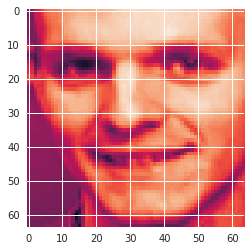

In [13]:
data = fetch_olivetti_faces()
X = data['data']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
plt.imshow(X_train[100, :].reshape(64, 64))

In [14]:
nmf = NMF(n_components=20, random_state=2)
nmf.fit(X_train)
X_reduce = nmf.transform(X_train)

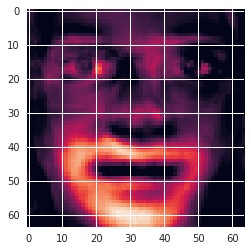

In [15]:
plt.imshow(nmf.components_[4, :].reshape(64, 64))

*Copyright &copy; 2020 The Data Incubator.  All rights reserved.*